# Aperture Photometry

`ztfimg` images (quadrant, ccd or focalplane) have a get_aperture() method that is based on [sep](https://sep.readthedocs.io).

This method expects aperture centroids (x,y) and radius (potentially a list of). You can provide specific data, mask, and error images. It also includes tools like background annulus subtractions etc. 

***
## Star aperture photometry

In [1]:
import ztfimg
qimg = ztfimg.ScienceQuadrant.from_filename("ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits",
                                   as_path=False)

let's get the gaia catalog associated to this quadrant

In [2]:
cat = qimg.get_catalog("gaia", in_fov=True)

let's see:

<IPython.core.display.Javascript object>


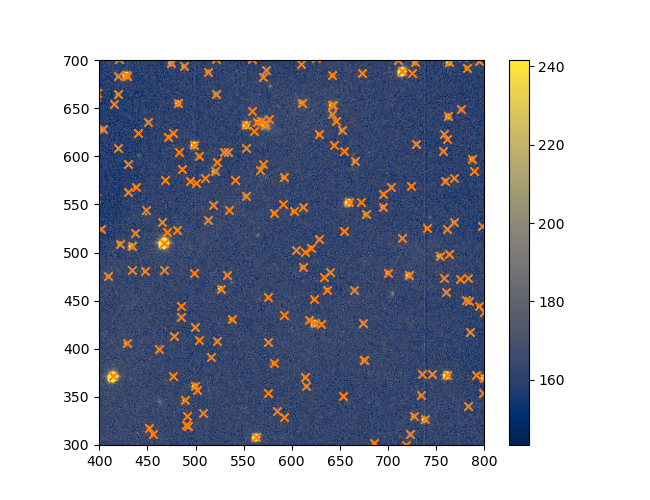

(300.0, 700.0)

In [4]:
%matplotlib notebook
fig = qimg.show()
ax = fig.axes[0]

ax.scatter(*cat[["x","y"]].values.T, marker="x", color="tab:orange")

ax.set_xlim(400,800)
ax.set_ylim(300,700)

Get the aperture photometry, using data masked for bad pixels. 

We will use a 5-pixel radius aperture and a background annulus between 5 and 6 to estimate their background

In [5]:
%%time
mask = qimg.get_mask()
flux, error, flag = qimg.get_aperture(*cat[["x","y"]].values.T, 5, 
                                      mask=mask, bkgann=[5,6])

CPU times: user 235 ms, sys: 30.6 ms, total: 266 ms
Wall time: 264 ms


and let's compare the observed magnitude with the gaia magnitude

In [11]:
import numpy as np
magztf = -2.5*np.log10(flux) # some flux are negative; this will lead to nans

/var/folders/kt/dnsb_cyx445cbz2ht_3l2m6w00029p/T/ipykernel_25071/3743219432.py:2: RuntimeWarning: invalid value encountered in log10
  magztf = -2.5*np.log10(flux) # some flux are negative; this will lead to nans


<IPython.core.display.Javascript object>


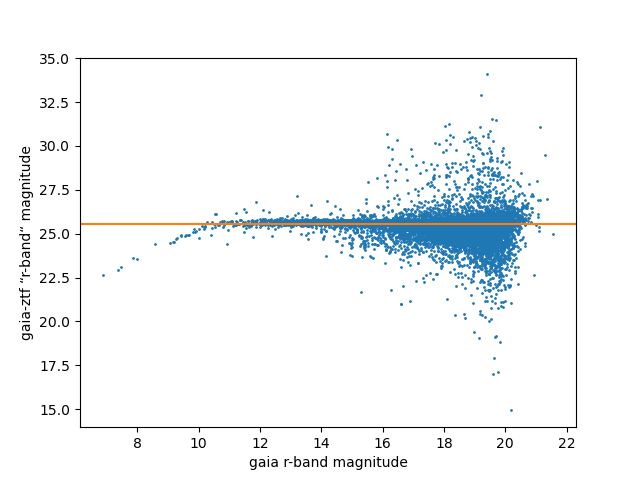

Text(0, 0.5, 'gaia-ztf “r-band“ magnitude')

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(cat["RPmag"], cat["RPmag"]-magztf, s=1, color="C0")
#ax.set_ylim(26,27)
ax.axhline(np.nanmedian(cat["RPmag"]-magztf), color="C1")

ax.set_xlabel("gaia r-band magnitude")
ax.set_ylabel("gaia-ztf “r-band“ magnitude")

In that figure, the orange band shows the median delta_magnitude. It is not centered at 0 because the image's zp is not calibrated. The tail toward brightert magnitude at agai-rmag<11 is the ztf camera saturation.

***
## Isolated stars

To avoid cross-contamination, between stars one may want to only focus on isolated stars. Let's get the "isolated" stars froml the gaia catalog by comparing it to itself.

In [19]:
from ztfimg import catalog

In [20]:
isolated = catalog.get_isolated(cat)
isolated

1800      True
1807      True
1808      True
1812      True
1815     False
         ...  
26296     True
26298    False
26299     True
26300     True
26311     True
Name: isolated, Length: 13899, dtype: bool

and let's also take the stars that are between 12 and 20 gaia magnitude

In [22]:
cat_good = cat[isolated & (cat["RPmag"].between(12,20))]

<IPython.core.display.Javascript object>


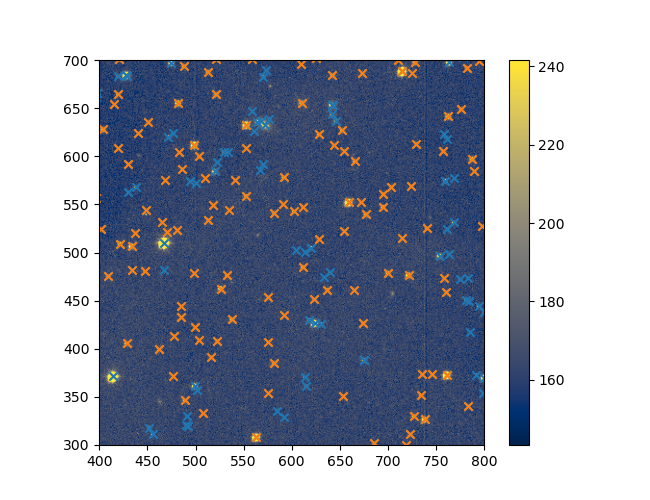

(300.0, 700.0)

In [25]:
%matplotlib notebook
fig = qimg.show()
ax = fig.axes[0]

ax.scatter(*cat[["x","y"]].values.T, marker="x", color="tab:blue") # blue means all
ax.scatter(*cat_good[["x","y"]].values.T, marker="x", color="tab:orange")# orange good isolated

ax.set_xlim(400,800)
ax.set_ylim(300,700)

In [27]:
%%time
mask = qimg.get_mask()
flux, error, flag = qimg.get_aperture(*cat_good[["x","y"]].values.T, 5, 
                                      mask=mask, bkgann=[5,6])

magztf_good = -2.5*np.log10(flux)

CPU times: user 225 ms, sys: 38.2 ms, total: 264 ms
Wall time: 262 ms


<timed exec>:5: RuntimeWarning: invalid value encountered in log10


<IPython.core.display.Javascript object>


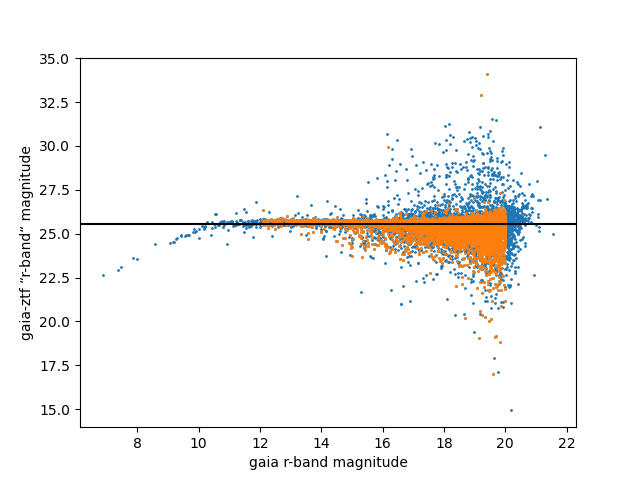

Text(0, 0.5, 'gaia-ztf “r-band“ magnitude')

In [31]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(cat["RPmag"], cat["RPmag"]-magztf, s=1, color="C0")
ax.scatter(cat_good["RPmag"], cat_good["RPmag"]-magztf_good, s=1, color="C1")
#ax.set_ylim(26,27)
ax.axhline(np.nanmedian(cat["RPmag"]-magztf), color="k")

ax.set_xlabel("gaia r-band magnitude")
ax.set_ylabel("gaia-ztf “r-band“ magnitude")

***
## use cleaned image

let's change the data on which the aperture photometry is ran, adding, this time, no background annulus correction

In [33]:
data_clean = qimg.get_data(apply_mask=True, rm_bkgd=True) # cleaned image

In [34]:
%%time
mask = qimg.get_mask()
flux, error, flag = qimg.get_aperture(*cat_good[["x","y"]].values.T, 5, 
                                      data=data_clean,
                                      mask=mask)

magztf_good_clean = -2.5*np.log10(flux)

CPU times: user 213 ms, sys: 21.2 ms, total: 234 ms
Wall time: 235 ms


<timed exec>:6: RuntimeWarning: invalid value encountered in log10


<IPython.core.display.Javascript object>


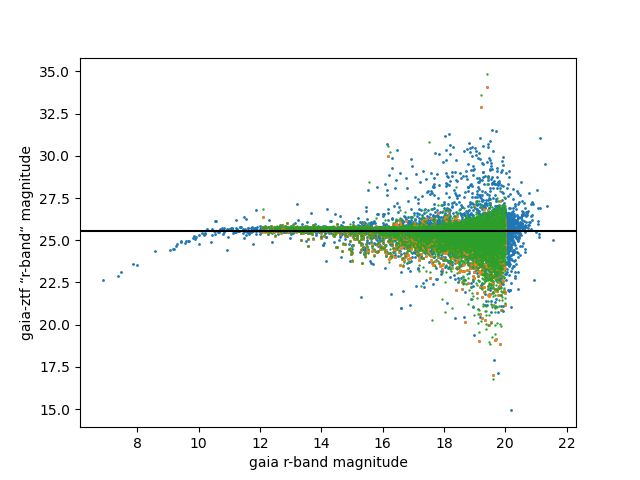

Text(0, 0.5, 'gaia-ztf “r-band“ magnitude')

In [38]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(cat["RPmag"], cat["RPmag"]-magztf, s=1, color="C0")
ax.scatter(cat_good["RPmag"], cat_good["RPmag"]-magztf_good, s=1, color="C1")
ax.scatter(cat_good["RPmag"], cat_good["RPmag"]-magztf_good_clean, s=0.5, color="C2")
#ax.set_ylim(26,27)
ax.axhline(np.nanmedian(cat["RPmag"]-magztf), color="k")

ax.set_xlabel("gaia r-band magnitude")
ax.set_ylabel("gaia-ztf “r-band“ magnitude")

***
## multiple radius at once

The code is vectorized so you gain a lot by providing multiple radius at once if that is what you want. 

Let's say we want 10 radii between 1 and 8-pixels

In [45]:
%%time
mask = qimg.get_mask()
radii = np.linspace(1, 8, 10)[:,None] # don't forget the broadcast !

flux, error, flag = qimg.get_aperture(*cat_good[["x","y"]].values.T, 
                                      radii, 
                                      data=data_clean,
                                      mask=mask)

CPU times: user 326 ms, sys: 25.2 ms, total: 351 ms
Wall time: 349 ms


In [40]:
flux.shape

(10, 8062)

### Aperture photometry correction

In [48]:
flux_normed = flux/flux[-1]

<IPython.core.display.Javascript object>


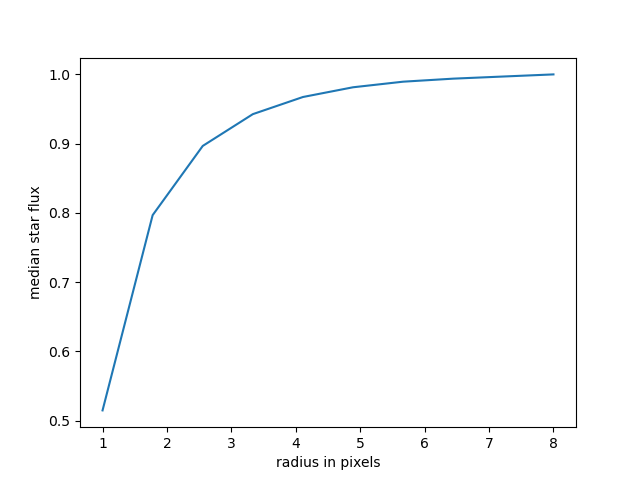

Text(0, 0.5, 'median star flux')

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)

median = np.nanmedian(flux_normed, axis=1)

ax.plot(radii, median)
ax.set_xlabel("radius in pixels")
ax.set_ylabel("median star flux")